In [98]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import *
from qiskit.tools.jupyter import *
from ibm_quantum_widgets import *
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
# import basic plot tools
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

#from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble

from qiskit import IBMQ

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-04-10 13:30:07,252: Credentials are already in use. The existing account in the session will be replaced.


## binary --> image

In [4]:
Text = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# convert int to bit string
def Binary(Text):
    '''
    a function that gives the binary reperesentation
    
    Parameters:
        Text (string) : input of string
    Returns:
        Bin (list) : binary reperesentation of each number with a length of 8
    '''
    Bin = []
    byte_obj = Text.encode('ascii')
    for i in range(len(Text)):
        Bin.append(np.binary_repr(byte_obj[i], width=8))
        print(Text[i],"index",i,"==>",Bin[i])
    return Bin

bin_list = Binary(Text)

A index 0 ==> 01000001
B index 1 ==> 01000010
C index 2 ==> 01000011
D index 3 ==> 01000100
E index 4 ==> 01000101
F index 5 ==> 01000110
G index 6 ==> 01000111
H index 7 ==> 01001000
I index 8 ==> 01001001
J index 9 ==> 01001010
K index 10 ==> 01001011
L index 11 ==> 01001100
M index 12 ==> 01001101
N index 13 ==> 01001110
O index 14 ==> 01001111
P index 15 ==> 01010000
Q index 16 ==> 01010001
R index 17 ==> 01010010
S index 18 ==> 01010011
T index 19 ==> 01010100
U index 20 ==> 01010101
V index 21 ==> 01010110
W index 22 ==> 01010111
X index 23 ==> 01011000
Y index 24 ==> 01011001
Z index 25 ==> 01011010


In [6]:
def Vazirani(Bin):
    '''
    a function that gives a list of Qcircuits
    
    Parameters:
        Bin (list) : binary reperesentation of each number with a length of 8
    Returns:
        circuit_list (list) : a list of circuits
    '''
    
    #a circuit for each character
    circuit_list = []
    
    n=8
    #binary string of each letter
    for i in range(len(Bin)):
        s = Bin[i] #string
        
        # Create the circuits
        
        # We need a circuit with n qubits, plus one auxiliary qubit
        # Also need n classical bits to write the output to
        bv_circuit = QuantumCircuit(n+1, n)

        # put auxiliary in state |->
        bv_circuit.h(n)
        bv_circuit.z(n)

        # Apply barrier 
        bv_circuit.barrier()

        # Apply Hadamard gates before querying the oracle , for all n qubits
        for i in range(n):
            bv_circuit.h(i)
    
        # Apply barrier 
        bv_circuit.barrier()

        # Apply the inner-product oracle
        s = s[::-1] # reverse s to fit qiskit's qubit ordering |..,2nd,1st,0th> 
        for q in range(n):
            if s[q] == '0':
                bv_circuit.i(q) #identity if it's 0
            else:
                bv_circuit.cx(q, n) #cnot if 1
        
        # Apply barrier 
        bv_circuit.barrier()

        #Apply Hadamard gates after querying the oracle
        for i in range(n):
            bv_circuit.h(i)
 
        # Apply barrier 
        bv_circuit.barrier()

        # Measurement
        for i in range(n):
            bv_circuit.measure(i, i)
            
        circuit_list.append(bv_circuit)
    
    return circuit_list
circuit = Vazirani(bin_list) # list of all circuits

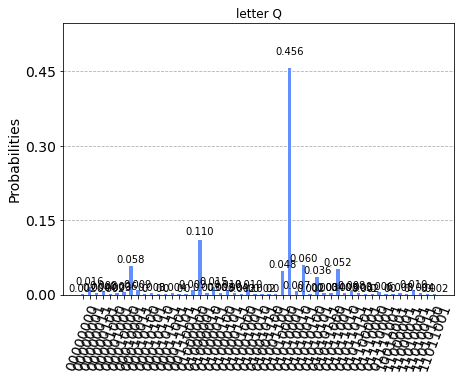

In [8]:
from qiskit.test.mock import FakeJohannesburg

fake_device = FakeJohannesburg()


results = execute(circuit, fake_device).result()
counts = results.get_counts()
plot_histogram(counts[16], title="letter Q")

In [91]:
prob = [] # probabilities
for k, v in counts[16].items(): # letter Q
    prob.append(v)
data_norm = prob / np.sqrt(np.sum(np.array(prob)**2))

Text(0.5, 1.0, "original 'Q'")

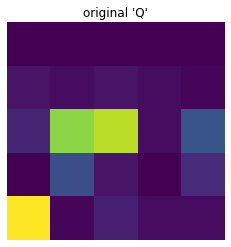

In [92]:
n_pixels = int(np.log2(len(data_norm)))
data= data_norm.copy()
data.resize((n_pixels,n_pixels))
fig, ax = plt.subplots()
ax.imshow(data)
plt.axis('off')
plt.title("original 'Q'")

## blur effect [1]

In [77]:
prob = []
for k, v in counts[0].items(): 
    prob.append(v)

In [78]:
if isinstance(np.log2(len(prob)), int): # vector dim has to be 2**n
    pass
else :
    missing = 2**(int(np.log2(len(prob)))+1) - 2**int(np.log2(len(prob)))
    for i in range(missing-5):
        prob.append(0)
data_norm = prob / np.sqrt(np.sum(np.array(prob)**2))

In [79]:
len(data_norm)

64

In [80]:
#initialize circuit
n_qubits = int(np.log2(len(data_norm)))

qc = QuantumCircuit(n_qubits, n_qubits)

qc.initialize(data_norm)

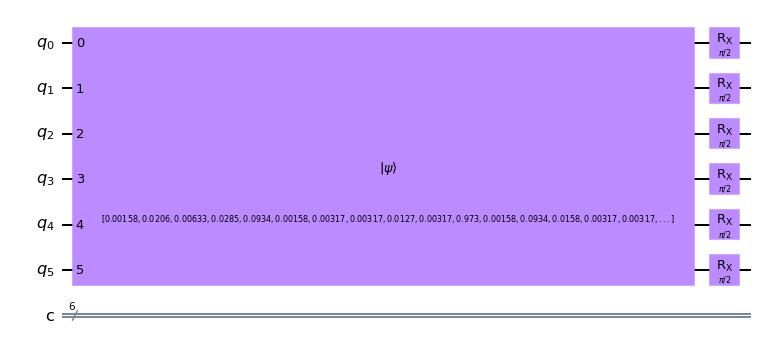

In [81]:
for i in range(n_qubits):
    qc.rx(np.pi/2,i)
qc.draw()

In [82]:
from qiskit import BasicAer, execute
simulator   = BasicAer.get_backend('statevector_simulator')
sim_result  = execute(qc, simulator).result()
final_state = sim_result.get_statevector(qc)

In [90]:
blur = np.real(final_state)
n_pixels = int(np.log2(len(blur)))
blur= blur.copy()
blur.resize((n_pixels,n_pixels))

(-0.5, 4.5, 4.5, -0.5)

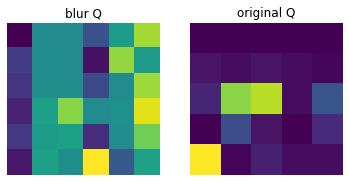

In [94]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(blur)
ax[0].set_title('blur Q')
ax[0].axis('off')
ax[1].imshow(data)
ax[1].set_title('original Q')
ax[1].axis('off')

descrete pixels

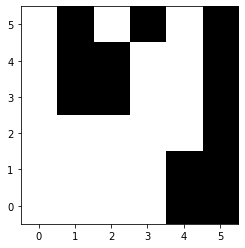

In [97]:
from matplotlib import colors
# make a color map of fixed colors
cmap = colors.ListedColormap(['white','black'])
bounds=[-1,0,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
img = plt.imshow(blur, interpolation='nearest', origin='lower',
                    cmap=cmap, norm=norm)
#plt.savefig("Q.png")
plt.show()

**Reference :**

[1] [Investigating the usefulness of Quantum Blur](https://arxiv.org/abs/2112.01646)